- Transformer中Position Embedding的意义：“破坏Transformer结构的完全对称性”。
    - 即对 sequence 中的 token 顺序敏感

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from typing import Tuple

## cis 编码

$$
\begin{split}
f(q,m)&=qe^{im\theta}\\
f(q,m)&=\begin{pmatrix}
\cos m\theta & -\sin m\theta\\
\sin m\theta & \cos m\theta
\end{pmatrix}\begin{pmatrix}
q_0\\
q_1
\end{pmatrix}\\
&=R_mq
\end{split}
$$

$$
\begin{split}
R(\alpha)R(\beta)&=R(\alpha+\beta)\\
R^T(\alpha)R(\beta)&=\begin{pmatrix}
\cos\alpha & \sin\alpha\\
-\sin\alpha & \cos\alpha
\end{pmatrix}\begin{pmatrix}
\cos\beta & -\sin\beta\\
\sin\beta & \cos\beta
\end{pmatrix}\\
&=R(-\alpha)R(\beta)\\
&=R(\beta-\alpha)
\end{split}
$$

$$
\begin{split}
f(q,m)^Tf(k,n)&=(R_mq)^T(R_nk)\\
&=q^T(R^T_mR_n)k\\
&=q^TR_{n-m}k
\end{split}
$$

In [43]:
def R(theta):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [44]:
R1 = R(30)
R2 = R(60)

In [45]:
R1.dot(R2)

array([[ 2.62681588e-16, -1.00000000e+00],
       [ 1.00000000e+00,  2.62681588e-16]])

In [51]:
R1.T.dot(R2)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

In [47]:
R(30+60)

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [50]:
R(60-30)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

## apply_rotary_emb


| **model** | **heads** | **layers** | **dim** | **head_dim** |
|-----------|-----------|------------|---------|--------------|
| 7b        | 32        | 32         | 4096    | 4096/32      |
| 13b       | 40        | 40         | 5120    | 5120/40      |
| 70b       | 64        | 80         | 8192    | 8192/64      |

- position encoding 直接作用于 q(query) 与 k(key)
    - `q = wq(x)`
    - `k = wk(x)`
- 是一种乘性，而非 sin position encoding 的加性；
    - BERT（Transformer库）的 position encoding 也是加性的；

`xq, xk = apply_rotary_emb(xq, xk, freqs_cis=freqs_cis)`
- input:
    - xq: [1, 8, 32, 128]
    - xk: [1, 8, 32, 128]
    - freqs_cis.shape: [8, 64]

In [71]:
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    # [1, 8, 32, 128] => [1, 8, 32, 64] (*2)
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    # [1, 8, 32, 128] => [1, 8, 32, 64] (*2)
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # [8, 64] => [1, 8, 1, 64]
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    
    # (xq_ * freqs_cis).shape == [1, 8, 32, 64]
    # torch.view_as_real(xq_ * freqs_cis).shape == [1, 8, 32, 64, 2]
    # flatten(3) == [1, 8, 32, 128]
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    
    # xq_out == [1, 8, 32, 128]
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [72]:
# self.params.dim // self.params.n_heads, self.params.max_seq_len * 2
# params.dim == 4096, n_heads == 32, 2^12/2^5 == 2^7 == 128
# params.max_seq_len == 1024
# freqs_cis = precompute_freqs_cis(4096//32, 2048)
# freqs_cis.shape

In [73]:
from sentencepiece import SentencePieceProcessor
sp_model = SentencePieceProcessor(model_file='./tokenizer.model')

In [74]:
prompt = 'I believe the meaning of life is'
[sp_model.bos_id(), *sp_model.encode(prompt)]

[1, 306, 4658, 278, 6593, 310, 2834, 338]

## 远程（$m-n$）衰减性

- Transformer升级之路：2、博采众长的旋转式位置编码
    - https://spaces.ac.cn/archives/8265/comment-page-1

$$
\begin{split}
&S_j=\sum_{i=0}^{j-1}\exp(i(m-n)\theta_i)\\
&\theta_i=10000^{-2i/d}
\end{split}
$$

In [36]:
def s(m, d=128):
    theta_i = lambda i: 10000**(-2*i/d)
    return np.sum([np.abs(np.sum(np.exp(1j*m*theta_i(np.arange(0, j))))) for j in range(0, d//2)])

In [37]:
d = 128
xs = np.arange(256)
ys = [s(x)/(d//2) for x in xs]

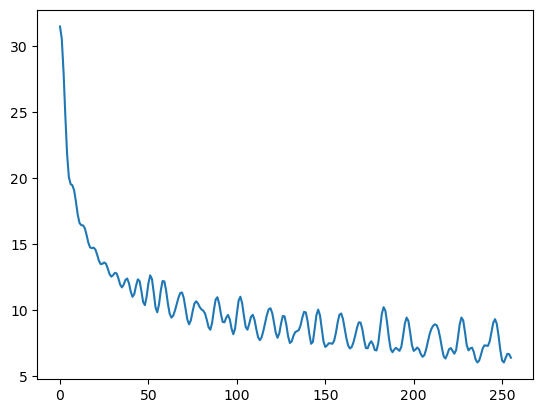

In [38]:
plt.plot(xs, ys)